In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics
import pyximport
pyximport.install()

Populating the interactive namespace from numpy and matplotlib


(None, <pyximport.pyximport.PyxImporter at 0x7f7020230828>)

In [2]:
raw_data = np.loadtxt('/home/sumit/ml-100k/u.data', delimiter='\t')

In [3]:
 from dataset import TripletsDataset

In [4]:
 ds = TripletsDataset(raw_data, threshold_user=60, rnd_seed=42)
 ds.train_test_split(n_train=50)

Split users:  90%|█████████ | 449/497 [00:00<00:00, 2050.39it/s]

In [5]:
# pickle.dump(ds, open('./tmp/ds.pkl', 'wb'))
# ds = pickle.load(open('./tmp/ds_50_mf.pkl', 'rb'))

In [5]:
ds.init_cached_random()

# define model

In [6]:
import tensorflow as tf
import bprnn

In [7]:
import imp

In [8]:
imp.reload(bprnn)

<module 'bprnn' from '/home/sumit/nnmf_ranking/nnmf/bprnn.py'>

In [48]:
# model.destroy()

In [27]:
N_USERS = 944 #int(max(raw_data[:, 0])) + 1
N_ITEMS = 3953 #int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS = 50

In [28]:
import tensorflow.contrib.slim as slim

def inner_network(user_emb, item_emb):
    joined_input = tf.concat(1, [user_emb, item_emb])
    net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
#     net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
#     net = slim.dro
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

In [29]:
model = bprnn.BPR_NN(N_USERS, N_ITEMS, N_EMBEDDINGS, alpha=1.0, beta=0, alpha_reg=0.0, inner_net=inner_network)
model.build_graph()
model.initialize_session()

In [30]:
losses = []
batch_size = 512
for n_batches, cur_optim in [(10000, model.trainer_3)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        el, nl, reg, t, _ = model.session.run(
            [model.embedding_loss, model.net_loss, model.regularization, model.target, cur_optim], 
            feed_dict=fd
        )
        losses.append((el, nl, reg, t))
        if i%500==0:
            user_norm = np.linalg.norm(model.weights_u)
            item_norm = np.linalg.norm(model.weights_i)
            print('[it {}] weight norms, users: {}, items: {}'.format(i, user_norm, item_norm))
            print('[it {}] metrics (emb_loss, net_loss, reg, target): {}'.format(i, losses[-1]))

  0%|          | 17/10000 [00:00<03:29, 47.58it/s]

[it 0] weight norms, users: 77.34105682373047, items: 62.930442810058594
[it 0] metrics (emb_loss, net_loss, reg, target): (0.70853019, 0.69340169, 3.0484443, 0.70853019)


  5%|▌         | 522/10000 [00:03<01:05, 144.48it/s]

[it 500] weight norms, users: 77.54983520507812, items: 62.09654235839844
[it 500] metrics (emb_loss, net_loss, reg, target): (0.65010059, 0.70061493, 3.1270266, 0.65010059)


 10%|█         | 1030/10000 [00:07<01:00, 148.53it/s]

[it 1000] weight norms, users: 79.74112701416016, items: 62.34030532836914
[it 1000] metrics (emb_loss, net_loss, reg, target): (0.58504152, 0.70333648, 3.5288265, 0.58504152)


 15%|█▌        | 1523/10000 [00:10<00:59, 141.65it/s]

[it 1500] weight norms, users: 82.76641845703125, items: 63.17744445800781
[it 1500] metrics (emb_loss, net_loss, reg, target): (0.59919262, 0.70403022, 3.9249868, 0.59919262)


 20%|██        | 2030/10000 [00:14<00:54, 146.28it/s]

[it 2000] weight norms, users: 85.9228286743164, items: 64.35868835449219
[it 2000] metrics (emb_loss, net_loss, reg, target): (0.5282774, 0.70467424, 4.3517847, 0.5282774)


 25%|██▌       | 2528/10000 [00:17<00:52, 141.58it/s]

[it 2500] weight norms, users: 88.97989654541016, items: 65.68140411376953
[it 2500] metrics (emb_loss, net_loss, reg, target): (0.53317988, 0.70270061, 4.5136185, 0.53317988)


 30%|███       | 3022/10000 [00:21<00:50, 137.43it/s]

[it 3000] weight norms, users: 91.72069549560547, items: 67.04741668701172
[it 3000] metrics (emb_loss, net_loss, reg, target): (0.50043464, 0.70750308, 5.1881618, 0.50043464)


 35%|███▌      | 3522/10000 [00:24<00:42, 152.12it/s]

[it 3500] weight norms, users: 94.23944854736328, items: 68.34233093261719
[it 3500] metrics (emb_loss, net_loss, reg, target): (0.48389506, 0.70406389, 5.3643951, 0.48389506)


 40%|████      | 4030/10000 [00:27<00:41, 144.74it/s]

[it 4000] weight norms, users: 96.54656219482422, items: 69.60066986083984
[it 4000] metrics (emb_loss, net_loss, reg, target): (0.49377501, 0.70782673, 5.8822002, 0.49377501)


 45%|████▌     | 4529/10000 [00:31<00:38, 142.38it/s]

[it 4500] weight norms, users: 98.64763641357422, items: 70.78959655761719
[it 4500] metrics (emb_loss, net_loss, reg, target): (0.46427977, 0.70821071, 5.9334311, 0.46427977)


 50%|█████     | 5016/10000 [00:34<00:35, 138.69it/s]

[it 5000] weight norms, users: 100.560791015625, items: 71.89558410644531
[it 5000] metrics (emb_loss, net_loss, reg, target): (0.4700906, 0.70501626, 6.3233304, 0.4700906)


 55%|█████▌    | 5518/10000 [00:38<00:31, 144.12it/s]

[it 5500] weight norms, users: 102.37281799316406, items: 72.97994995117188
[it 5500] metrics (emb_loss, net_loss, reg, target): (0.44489598, 0.70516729, 6.3320608, 0.44489598)


 60%|██████    | 6026/10000 [00:41<00:26, 147.57it/s]

[it 6000] weight norms, users: 104.06134796142578, items: 73.99163818359375
[it 6000] metrics (emb_loss, net_loss, reg, target): (0.46869874, 0.70888555, 6.7141633, 0.46869874)


 65%|██████▌   | 6518/10000 [00:45<00:23, 148.05it/s]

[it 6500] weight norms, users: 105.61254119873047, items: 74.98857879638672
[it 6500] metrics (emb_loss, net_loss, reg, target): (0.46705964, 0.70154798, 6.7897272, 0.46705964)


 70%|███████   | 7020/10000 [00:48<00:20, 147.41it/s]

[it 7000] weight norms, users: 107.10636138916016, items: 75.97007751464844
[it 7000] metrics (emb_loss, net_loss, reg, target): (0.47428116, 0.70442253, 7.0190325, 0.47428116)


 75%|███████▌  | 7530/10000 [00:52<00:16, 147.85it/s]

[it 7500] weight norms, users: 108.4815902709961, items: 76.85244750976562
[it 7500] metrics (emb_loss, net_loss, reg, target): (0.46208704, 0.70743942, 7.1428299, 0.46208704)


 80%|████████  | 8027/10000 [00:56<00:14, 136.54it/s]

[it 8000] weight norms, users: 109.81381225585938, items: 77.71915435791016
[it 8000] metrics (emb_loss, net_loss, reg, target): (0.44220495, 0.70188463, 7.332922, 0.44220495)


 85%|████████▌ | 8524/10000 [00:59<00:10, 141.59it/s]

[it 8500] weight norms, users: 111.02297973632812, items: 78.5417709350586
[it 8500] metrics (emb_loss, net_loss, reg, target): (0.43515632, 0.70286089, 7.3391666, 0.43515632)


 90%|█████████ | 9022/10000 [01:02<00:06, 143.43it/s]

[it 9000] weight norms, users: 112.17588806152344, items: 79.30311584472656
[it 9000] metrics (emb_loss, net_loss, reg, target): (0.42468619, 0.70627141, 7.7736473, 0.42468619)


 95%|█████████▌| 9527/10000 [01:06<00:03, 148.08it/s]

[it 9500] weight norms, users: 113.2666015625, items: 80.08767700195312
[it 9500] metrics (emb_loss, net_loss, reg, target): (0.42614955, 0.70893949, 7.6125226, 0.42614955)


100%|██████████| 10000/10000 [01:09<00:00, 143.42it/s]


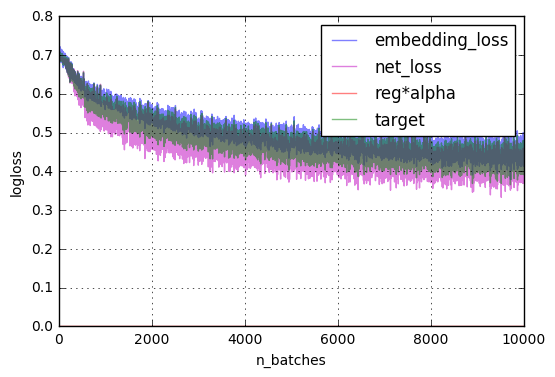

In [53]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='m', label='net_loss', alpha=0.5)
plot([x[2]*model.alpha_reg for x in losses], c='r', label='reg*alpha', alpha=0.5)
plot([x[3] for x in losses], c='g', label='target', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [31]:
ndcg_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    response = np.zeros(len(ds.test[u]))
    fd = {
            model.user_ids:  (np.ones(len(ds.test[u]))*u).astype(np.int32), 
            model.left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response += model.session.run(model.embedding_left, feed_dict=fd)[:, 0]
    response += model.session.run(model.left_output, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    gain = letor_metrics.ndcg_from_ranking(relevances, predicted_ranking, 10)
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 3938/3938 [00:07<00:00, 553.31it/s]


In [32]:
np.mean(ndcg_vals)

0.67532712374057247